# ULTRAsound EDA
by Angikaar Chana

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

## Summary Statistics

### Counting Number of Images

In [2]:
def count_non_mask_images(directory):
    # Initialize counter
    count = 0

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        # Check if "mask" is not in the filename
        if "mask" not in filename:
            count += 1

    return count

# Use the function on your directory
normal_count = count_non_mask_images("../data/kaggle/normal")
benign_count = count_non_mask_images("../data/kaggle/benign")
malignant_count = count_non_mask_images("../data/kaggle/malignant")

print(normal_count, benign_count, malignant_count)

133 437 210


### Counting Number of Mask Images

In [3]:
def count_mask_images(directory):
    # Initialize counter
    count = 0

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        # Check if "mask" is not in the filename
        if "mask" in filename:
            count += 1

    return count

# Use the function on your directory
normal_count = count_mask_images("../data/kaggle/normal")
benign_count = count_mask_images("../data/kaggle/benign")
malignant_count = count_mask_images("../data/kaggle/malignant")

print(normal_count, benign_count, malignant_count)

133 454 211


### Counting Number of Multiple Tumors

In [4]:
def count_multiple_tumors(directory):
    # Initialize counters
    one_tumor_count = 0
    two_tumors_count = 0
    three_tumors_count = 0

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        # Check if "mask" is in the filename
        if "mask" in filename:
            # Check for multiple tumors
            if "_1" in filename:
                one_tumor_count -= 1
                two_tumors_count += 1
            elif "_2" in filename:
                two_tumors_count -=1
                three_tumors_count += 1
            else:
                one_tumor_count += 1

    return one_tumor_count, two_tumors_count, three_tumors_count

# Use the function on your directory
normal_counts = count_multiple_tumors("../data/kaggle/normal")
benign_counts = count_multiple_tumors("../data/kaggle/benign")
malignant_counts = count_multiple_tumors("../data/kaggle/malignant")

print(normal_counts, benign_counts, malignant_counts)

(133, 0, 0) (421, 15, 1) (209, 1, 0)


### Average Size of Images

In [5]:
def calculate_image_stats(directory):
    # Get a list of all non-mask images in the directory
    images = [f for f in os.listdir(directory) if \
              os.path.isfile(os.path.join(directory, f)) and "mask" not in f]

    # Calculate the size of each non-mask image
    image_sizes = []
    for image in images:
        with Image.open(os.path.join(directory, image)) as img:
            width, height = img.size
            image_sizes.append((width, height))

    # Calculate summary statistics
    df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
    mean = df.mean()
    std_dev = df.std()

    # Calculate image count and ratios
    image_count = len(images)
    mean_ratio = mean['Width'] / mean['Height']
    std_dev_ratio = std_dev['Width'] / std_dev['Height']

    return mean, std_dev, image_count, mean_ratio, std_dev_ratio

# Use the function on your directories
normal_stats = calculate_image_stats("../data/kaggle/normal")
benign_stats = calculate_image_stats("../data/kaggle/benign")
malignant_stats = calculate_image_stats("../data/kaggle/malignant")

# Create a DataFrame to store the statistics
stats_df = pd.DataFrame({
    'Directory': ['Normal', 'Benign', 'Malignant'],
    'Image Count': [normal_stats[2], benign_stats[2], malignant_stats[2]],
    'Mean Width': [normal_stats[0]['Width'], benign_stats[0]['Width'], malignant_stats[0]['Width']],
    'Mean Height': [normal_stats[0]['Height'], benign_stats[0]['Height'], malignant_stats[0]['Height']],
    'Mean W/H Ratio': [normal_stats[3], benign_stats[3], malignant_stats[3]],
    'Std Dev Width': [normal_stats[1]['Width'], benign_stats[1]['Width'], malignant_stats[1]['Width']],
    'Std Dev Height': [normal_stats[1]['Height'], benign_stats[1]['Height'], malignant_stats[1]['Height']],
    'Std Dev W/H Ratio': [normal_stats[4], benign_stats[4], malignant_stats[4]]
})

stats_df

,Directory,Image Count,Mean Width,Mean Height,Mean W/H Ratio,Std Dev Width,Std Dev Height,Std Dev W/H Ratio
0,Normal,133,651.172932,532.849624,1.222058,126.058278,86.924514,1.450204
1,Benign,437,613.386728,495.471396,1.237986,117.258102,78.141469,1.500587
2,Malignant,210,597.971429,494.014286,1.210433,125.221141,60.434668,2.072008


## Tumor Size EDA

In [6]:
# Directories where the mask images are located
directories = ["../data/kaggle/malignant", "../data/kaggle/benign"]

# Initialize two empty lists to store the data for the two dataframes
data_sizes = []
data_ratios = []

for directory in directories:
    # Initialize counters and lists to store the sizes and ratios
    count = 0
    sizes = []
    ratios = []

    # Parse through files in the directory
    for filename in os.listdir(directory):
        # Check if 'mask' is in the filename
        if 'mask' in filename:
            # Construct the full file path
            filepath = os.path.join(directory, filename)

            # Load the image in grayscale mode
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

            # Count white pixels
            white_pixels = np.sum(img == 255)

            # Calculate the ratio of white pixels to total pixels
            ratio = white_pixels / (img.shape[0] * img.shape[1])

            # If there are white pixels, increment the counter and add the size and ratio to the lists
            if white_pixels > 0:
                count += 1
                sizes.append(white_pixels)
                ratios.append(ratio)

    # Calculate the statistics for sizes
    min_size = np.min(sizes) if sizes else np.nan
    mean_size = np.mean(sizes) if sizes else np.nan
    max_size = np.max(sizes) if sizes else np.nan
    median_size = np.median(sizes) if sizes else np.nan
    std_size = np.std(sizes) if sizes else np.nan

    # Add the data to the sizes list
    data_sizes.append([directory, count, min_size, mean_size, max_size, median_size, std_size])

    # Calculate the statistics for ratios
    min_ratio = np.min(ratios) if ratios else np.nan
    mean_ratio = np.mean(ratios) if ratios else np.nan
    max_ratio = np.max(ratios) if ratios else np.nan
    median_ratio = np.median(ratios) if ratios else np.nan
    std_ratio = np.std(ratios) if ratios else np.nan

    # Add the data to the ratios list
    data_ratios.append([directory, count, min_ratio, mean_ratio, max_ratio, median_ratio, std_ratio])

# Create the dataframes from the data lists
tumor_sizes = pd.DataFrame(data_sizes, \
                           columns=['Directory', 'Count', 'Min Size',
                                    'Mean Size', 'Max Size',
                                    'Median Size', 'Std Size'])
tumor_ratios = pd.DataFrame(data_ratios, \
                            columns=['Directory', 'Count', 'Min Ratio',
                                     'Mean Ratio', 'Max Ratio',
                                     'Median Ratio', 'Std Ratio'])

In [7]:
tumor_sizes

,Directory,Count,Min Size,Mean Size,Max Size,Median Size,Std Size
0,../data/kaggle/malignant,211,569,43243.843602,167411,34368.0,32976.154203
1,../data/kaggle/benign,454,624,20634.993392,209121,9961.0,28795.372083


In [8]:
tumor_ratios

,Directory,Count,Min Ratio,Mean Ratio,Max Ratio,Median Ratio,Std Ratio
0,../data/kaggle/malignant,211,0.002123,0.146738,0.562924,0.119810,0.107025
1,../data/kaggle/benign,454,0.002418,0.066276,0.512973,0.035644,0.081133


## Visual/Image Differences between Normal, Benign, and Malignant Tissue

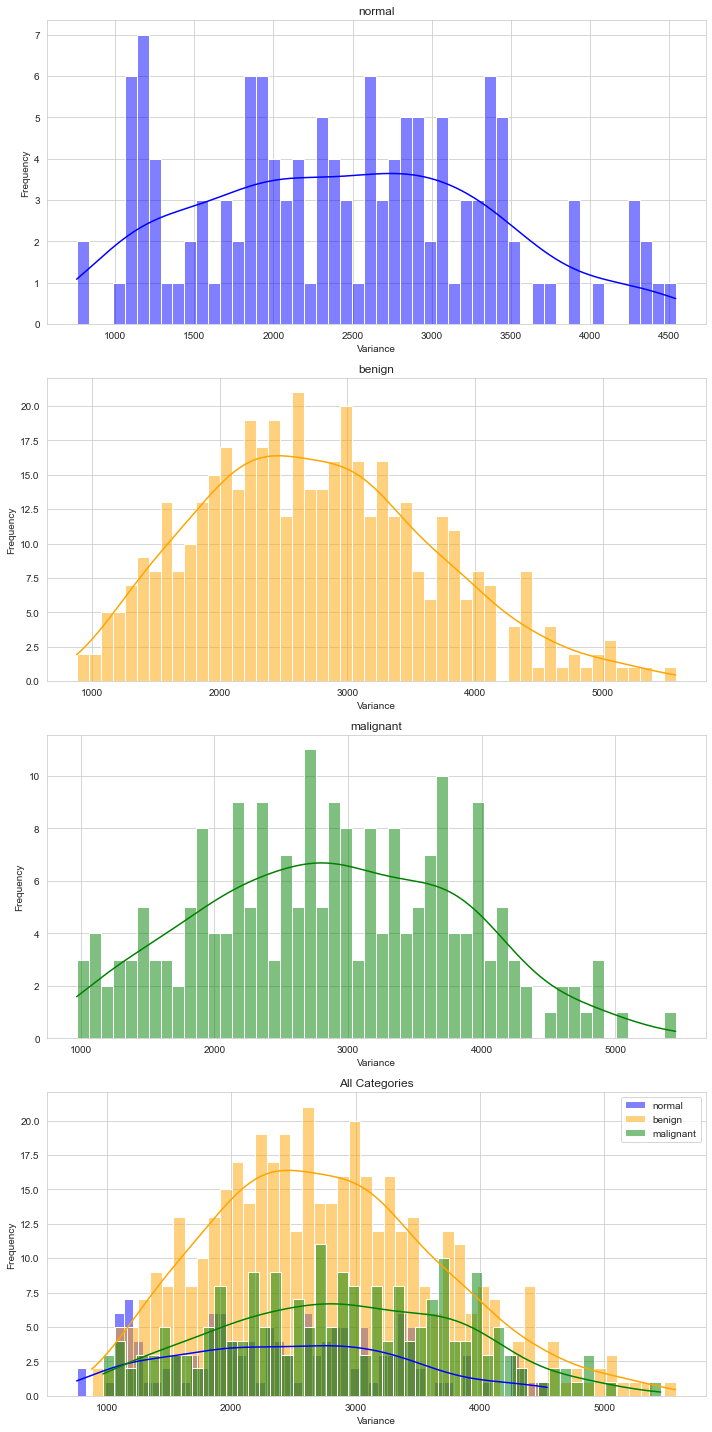

In [11]:
def calculate_and_plot_variance_histograms(directories):
    # Initialize a dictionary to store the variances
    variances = {"normal": [], "benign": [], "malignant": []}

    # Loop over the directories
    for directory in directories:
        # Get the category from the directory name
        category = os.path.basename(directory)

        # Loop over the files in the directory
        for filename in os.listdir(directory):
            if "mask" not in filename:

                # Construct the full file path
                filepath = os.path.join(directory, filename)

                # Load the image in grayscale
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

                # Calculate the variance of the image
                variance = np.var(img)

                # Add the variance to the list for this category
                variances[category].append(variance)

    # Create a figure and axes for the histograms
    fig, axs = plt.subplots(4, 1, figsize=(10, 20))

    # Define the colors for each histogram
    colors = ["blue", "orange", "green"]

    # Plot the individual histograms
    for ax, (category, variance_list), color in zip(axs[:-1], variances.items(), colors):
        sns.histplot(variance_list, bins=50, ax=ax, color=color, kde=True)
        ax.set_title(category)
        ax.set_xlabel('Variance')
        ax.set_ylabel('Frequency')

    # Plot the overlapping histogram
    for category, variance_list, color in zip(variances.keys(), variances.values(), colors):
        sns.histplot(variance_list, bins=50, ax=axs[-1], color=color, kde=True, label=category)
    axs[-1].set_title('All Categories')
    axs[-1].set_xlabel('Variance')
    axs[-1].set_ylabel('Frequency')
    axs[-1].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

calculate_and_plot_variance_histograms(directories)

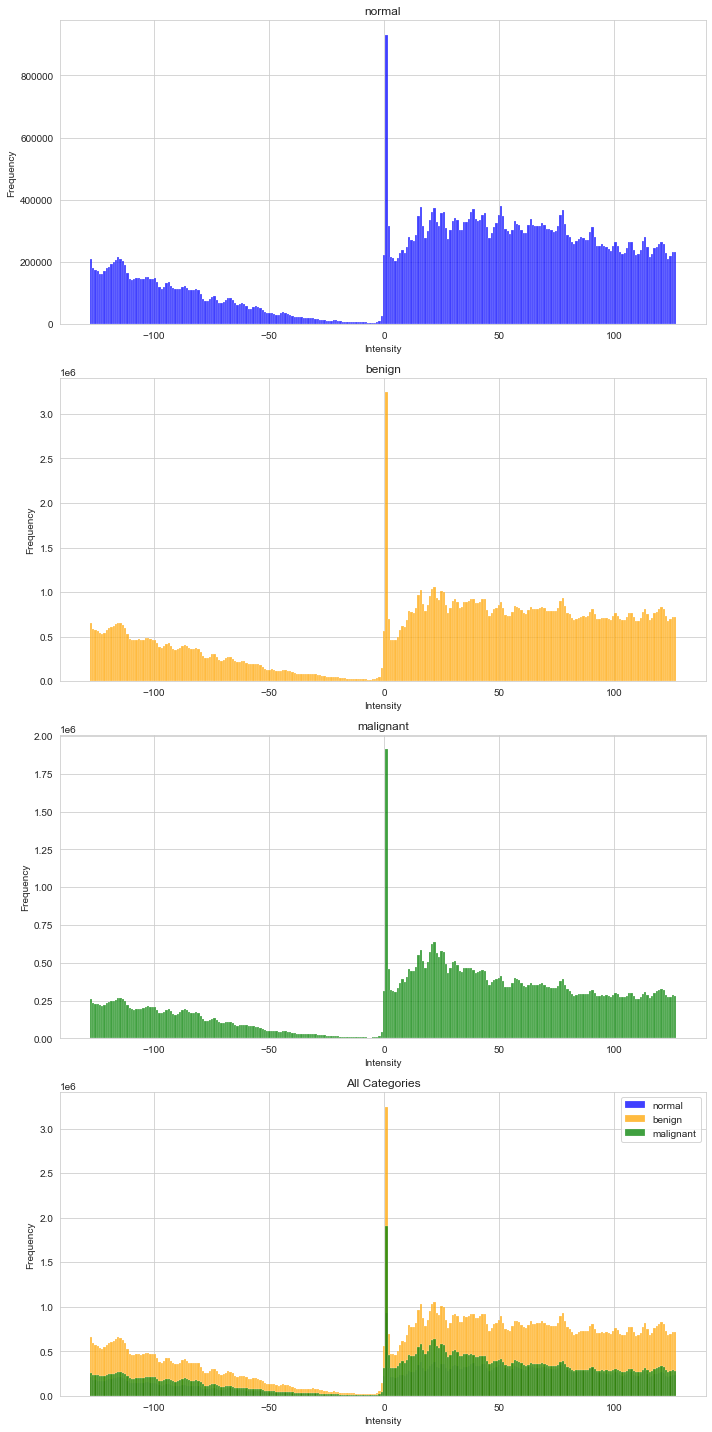

In [12]:
def calculate_and_plot_intensity_histograms(directories):
    # Initialize a dictionary to store the intensities
    intensities = {"normal": [], "benign": [], "malignant": []}

    # Loop over the directories
    for directory in directories:
        # Get the category from the directory name
        category = os.path.basename(directory)

        # Loop over the files in the directory
        for filename in os.listdir(directory):
            if "mask" not in filename:

                # Construct the full file path
                filepath = os.path.join(directory, filename)

                # Load the image in grayscale
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

                # Flatten the image array and add the intensities to the list for this category
                intensities[category].extend(img.flatten())

    # Create a figure and axes for the histograms
    fig, axs = plt.subplots(4, 1, figsize=(10, 20))

    # Define the colors for each histogram
    colors = ["blue", "orange", "green"]

    # Plot the individual histograms
    for ax, (category, intensity_list), color in zip(axs[:-1], intensities.items(), colors):
        sns.histplot(intensity_list, bins=256, ax=ax, color=color)
        ax.set_title(category)
        ax.set_xlabel('Intensity')
        ax.set_ylabel('Frequency')

    # Plot the overlapping histogram
    for category, intensity_list, color in zip(intensities.keys(), intensities.values(), colors):
        sns.histplot(intensity_list, bins=256, ax=axs[-1], color=color, label=category)
    axs[-1].set_title('All Categories')
    axs[-1].set_xlabel('Intensity')
    axs[-1].set_ylabel('Frequency')
    axs[-1].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

calculate_and_plot_intensity_histograms(directories)